In [1]:
import os
import logging
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import missingno as msno
import seaborn as sns
import numpy as np
plt.rcParams['figure.dpi'] = 140
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [2]:
def get_logger(log_path):
    logger = logging.getLogger('netflix_logger')
    if not logger.handlers:
        handler = logging.FileHandler(log_path)
        handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
        logger.addHandler(handler)
        logger.setLevel(logging.INFO)
    return logger

# Set log directory explicitly for environments where __file__ is not defined
log_directory = 'logs'
os.makedirs(log_directory, exist_ok=True)  # Create the directory if it doesn't exist
log_path = os.path.join(log_directory, 'netflix_data_viz_log.log')

# Use the logger
logger = get_logger(log_path)
logger.info('Logger initialized successfully.')


In [3]:
def read_data(filename):
    try:
        data = pd.read_csv(filename, low_memory=False)
        logger.info('Data loaded to dataframe sucessfully!')
        return data
        
    except FileNotFoundError:
        print(f"Error: The file {filename} was not found.")
        logger.error(f"Error: The file {filename} was not found.")
        #return f"Error: {str(e)}"
        
    except pd.errors.EmptyDataError:
        print(f"Error: The file {filename} is empty.")
        logger.error(f"Error: The file {filename} is empty.")
        #return f"Error: {str(e)}"
    
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        logger.error(f"An unexpected error occurred: {e}")                

In [4]:

def unzip_file(zip_path, extract_to):
    """
    Unzips the provided ZIP file to the specified directory.
    
    :param zip_path: Path to the zip file.
    :param extract_to: Directory where the contents will be extracted.
    """
    # Check if the zip file exists
    if not os.path.exists(zip_path):
        print(f"Error: {zip_path} does not exist.")
        return

    # Create the output folder if it doesn't exist
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_to)
        print(f"Files extracted successfully to: {extract_to}")

In [5]:
zip_file_path = "netflix_data.zip"  # Path to the zip file
output_folder = "Netflix_shows_movies"  # Folder where files will be extracted

# Call the function to unzip the files
unzip_file(zip_file_path, output_folder)

Files extracted successfully to: Netflix_shows_movies


In [6]:
netflix_data = read_data("Netflix_shows_movies/netflix_data.csv")

netflix_data.head(3)

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   

     rating  duration                           listed_in  \
0     TV-PG    90 min  Children & Family Movies, Comedies   
1     TV-MA    94 min                     Stand-Up Comedy   
2  TV-Y7-FV  1 Season                            Kids' TV   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...

## Data Cleansing

In [7]:
print(netflix_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB
None


#### Using `df.info()` it is clear that some of  the columns (**director,cast and country**) contains higher records of null 

#### Observing it more closely with some form of vizualization shows more insight around the missing values or data for the director, cast and country columns for a sample size of *1,000* 

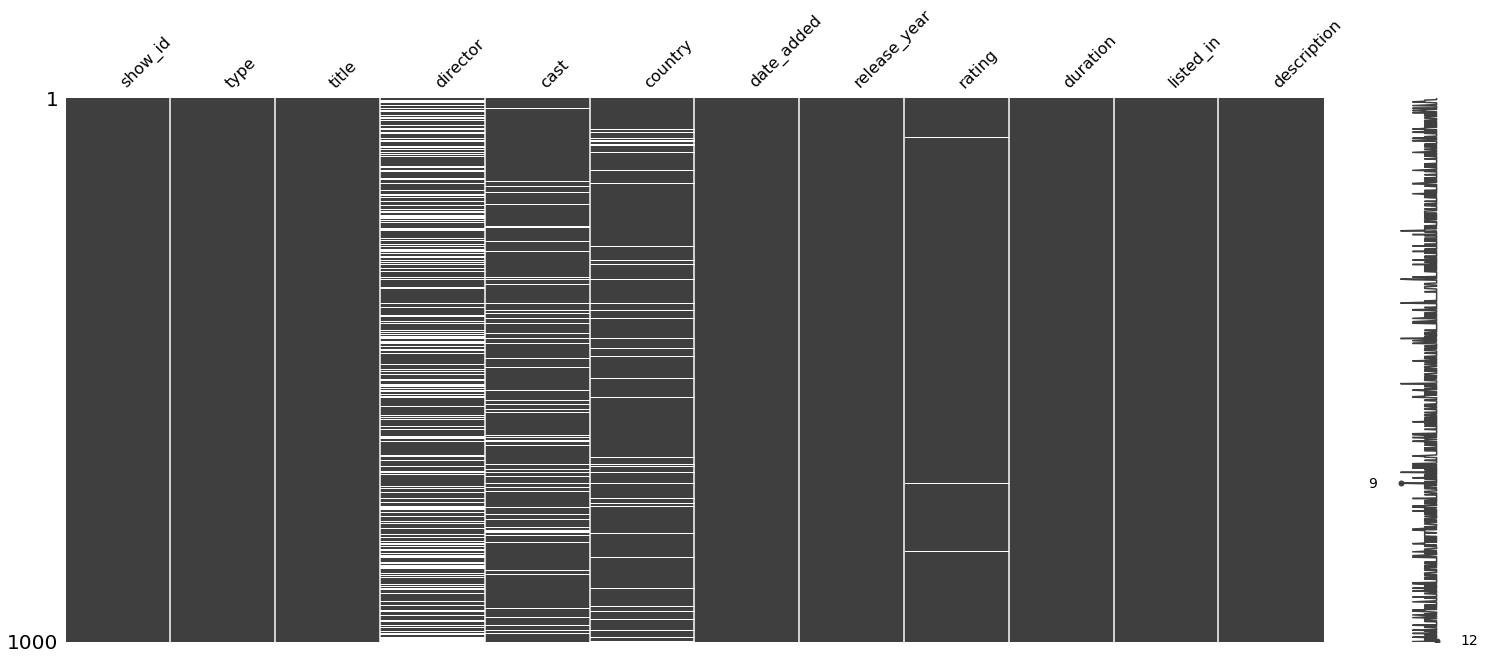

In [8]:
%matplotlib inline
msno.matrix(netflix_data.sample(1000))
plt.show()

#### We'll dive in deeper by showing the percentage rate to which the those 3 columns are to the total records 

In [9]:
for record in netflix_data.columns:
    null_rate = netflix_data[record].isna().sum() / len(netflix_data) * 100 
    print(f"{record} null rate: {round(null_rate,2)}%")

show_id null rate: 0.0%
type null rate: 0.0%
title null rate: 0.0%
director null rate: 31.58%
cast null rate: 9.14%
country null rate: 7.64%
date_added null rate: 0.18%
release_year null rate: 0.0%
rating null rate: 0.16%
duration null rate: 0.0%
listed_in null rate: 0.0%
description null rate: 0.0%


#### The above code indicates that there are 5 major columns with null or missing records and **director** column contribute a larger share.

#### We'll focus our energy on the 3 columns with null rate percentage above **1%**

## Resolving Missing values

#### Although there're several strategies that could be employed in cleaning and resolving null values, e.g filling with mean, median or mode values, also we can categories them as *"unknown"*

#### For our case, we represent missing value for `director` and `cast` as `Not available` and fill `country` column with **`mode`**

In [10]:
netflix_data['country'] = netflix_data['country'].fillna(netflix_data['country'].mode()[0])


netflix_data['cast'].replace(np.nan, 'Not Available',inplace  = True)
netflix_data['director'].replace(np.nan, 'Not Available',inplace  = True)


In [11]:

# Droping NAs if available at all

netflix_data.dropna(inplace=True)

# Drop Duplicates as well

netflix_data.drop_duplicates(inplace= True)

#### Checking the netflix_data again using `df.info()` indicates all nulls or missing records have be resolved.

In [12]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6214 entries, 0 to 6222
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6214 non-null   int64 
 1   type          6214 non-null   object
 2   title         6214 non-null   object
 3   director      6214 non-null   object
 4   cast          6214 non-null   object
 5   country       6214 non-null   object
 6   date_added    6214 non-null   object
 7   release_year  6214 non-null   int64 
 8   rating        6214 non-null   object
 9   duration      6214 non-null   object
 10  listed_in     6214 non-null   object
 11  description   6214 non-null   object
dtypes: int64(2), object(10)
memory usage: 631.1+ KB


## Data Exploration

#### Below shows the statistic of the netflix dataset by columns

In [13]:
# Overview of dataset statistics
print(netflix_data.describe(include='all'))

# Basic info like column types, number of entries, etc.
#print(netflix_data.info())


             show_id   type title       director           cast  \
count   6.214000e+03   6214  6214           6214           6214   
unique           NaN      2  6153           3299           5456   
top              NaN  Movie  Love  Not Available  Not Available   
freq             NaN   4257     3           1955            567   
mean    7.670547e+07    NaN   NaN            NaN            NaN   
std     1.095708e+07    NaN   NaN            NaN            NaN   
min     2.477470e+05    NaN   NaN            NaN            NaN   
25%     8.003642e+07    NaN   NaN            NaN            NaN   
50%     8.016396e+07    NaN   NaN            NaN            NaN   
75%     8.024503e+07    NaN   NaN            NaN            NaN   
max     8.123573e+07    NaN   NaN            NaN            NaN   

              country       date_added  release_year rating  duration  \
count            6214             6214   6214.000000   6214      6214   
unique            554             1521           

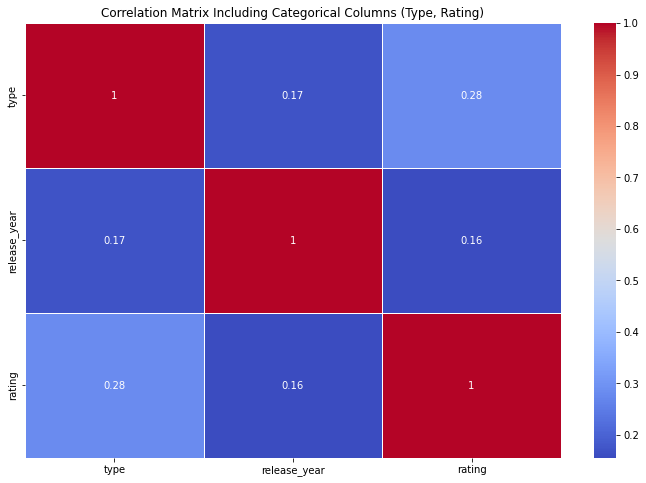

In [14]:
# Convert 'type' and 'rating' to categorical variables
# Map 'type' to numeric: 'Movie' -> 0, 'TV Show' -> 1

netflix_data_copy = netflix_data.copy()
netflix_data_copy['type'] = netflix_data_copy['type'].map({'Movie': 0, 'TV Show': 1})

# Convert 'rating' to numeric categories
# Create a mapping for 'rating' (example, adapt based on the dataset)
rating_mapping = {'PG': 0, 'PG-13': 1, 'R': 2, 'G': 3, 'TV-MA': 4, 'TV-14': 5, 'TV-PG': 6, 'TV-G': 7, 'NC-17': 8}
netflix_data_copy['rating'] = netflix_data_copy['rating'].map(rating_mapping)

# Drop any non-numeric columns
# Ensure 'show_id' and other non-numerical columns are excluded for correlation
numeric_columns = netflix_data_copy.select_dtypes(include=['float64', 'int64']).drop(columns=['show_id'], errors='ignore')

# Step 4: Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Step 5: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Including Categorical Columns (Type, Rating)')
plt.show()


In [15]:
# Correlation matrix for numerical features
correlation_matrix = netflix_data_copy.corr()
print(correlation_matrix)


               show_id      type  release_year    rating
show_id       1.000000  0.146816      0.566600  0.310993
type          0.146816  1.000000      0.169024  0.283322
release_year  0.566600  0.169024      1.000000  0.155468
rating        0.310993  0.283322      0.155468  1.000000


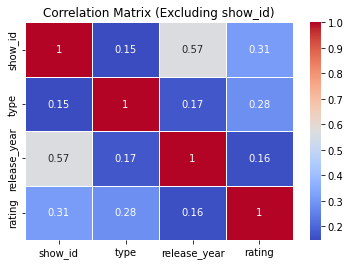

In [16]:
# Visualize correlation matrix
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Excluding show_id)')
plt.show()

In [17]:
# Skewness and Kurtosis for numerical columns
skewness = netflix_data_copy.skew()
kurtosis = netflix_data_copy.kurt()
print(f'Skewness: \n{skewness}')
print(f'Kurtosis: \n{kurtosis}')

Skewness: 
show_id        -5.147819
type            0.797050
release_year   -3.702629
rating         -0.907086
dtype: float64
Kurtosis: 
show_id         30.273922
type            -1.365151
release_year    18.280705
rating           0.592593
dtype: float64


#### We could not really talk more about correlation among the columns because they are not numerical columns and converting them to categorical data may be problematic because of the number of unique values in each columns

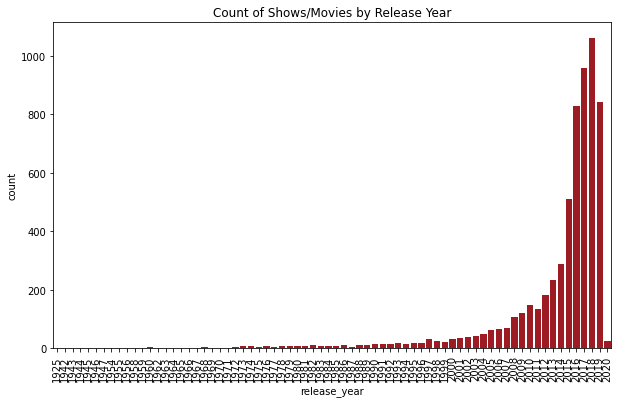

In [18]:
# Plot the count of shows/movies by release year
plt.figure(figsize=(10,6))
sns.countplot(x='release_year', data=netflix_data,color='#b20710')
plt.xticks(rotation=90)
plt.title('Count of Shows/Movies by Release Year')
plt.show()


#### Above shows most movies were released in year 2018 

In [19]:
import plotly.figure_factory as ff
# Extract the numeric part of the 'duration' column and convert to integer

df = netflix_data.copy()
df['duration_numeric'] = df['duration'].str.extract('(\d+)').astype(int)
df3 = df[df["type"] == "Movie"]

x1 = df3['duration_numeric'].fillna(0.0).astype(float)
fig = ff.create_distplot([x1], ['Movie'], bin_size=0.7, curve_type='normal', colors=["#b20710"])
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

Looking at the distribution plot in the image, the data appears to be **positively skewed (right-skewed)**. This means that:

1. Most of the movies' durations are concentrated on the left side (with shorter durations), while fewer movies have longer durations.
2. The right tail of the distribution is longer, indicating a gradual decline in the frequency of movies as the duration increases.
3. The peak (mode) is on the shorter duration side, with the bulk of the movies having relatively shorter lengths.

This suggests that the majority of movies in the dataset tend to have shorter run times, while fewer movies extend into much longer durations.

In [27]:
df['duration_numeric'] = df['duration'].str.extract('(\d+)').astype(int)
df3 = df[df["type"] == "TV Show"]

x1 = df3['duration_numeric'].fillna(0.0).astype(float)
fig = ff.create_distplot([x1], ['TV Show'], bin_size=0.7, curve_type='normal', colors=["#221f1f"])
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

The distribution plot for TV shows shows a strong **right skew** as well. Here’s what can be inferred:

1. **Highly skewed to the right:** Most TV shows have a low duration (likely in terms of seasons or number of episodes), with very few shows having a higher duration.
2. **Peak at the lower end:** There is a significant concentration of TV shows with smaller durations, as indicated by the tall bar on the left.
3. **Long tail on the right:** The tail stretches to the right, meaning there are some TV shows with larger durations, but these are much less common.

This suggests that most TV shows in the dataset are shorter, and only a few span a long duration (likely indicating a higher number of seasons or episodes).

## Data Visualization

In [106]:
# Genres
from sklearn.preprocessing import MultiLabelBinarizer 

import matplotlib.colors


# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])



def genre_heatmap(df, title,text_):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(20, 14))
    fig.text(.56,.83,'Genre correlation', fontfamily='serif',fontweight='bold',fontsize=28)
    text_ = fig.text(.75,.665,text_, fontfamily='serif',fontsize=14,ha='right')
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    
    plt.show()

## Generating Heatmap for Entire Datasets for the Most Watched Genres

In [181]:
text_ =     ('''
             It is interesting to see that most of "International Movies"
             are in the category of Drama and comedy. 
             
             Also the British TV hardly show "Docuseries" content.
             
             International TV shows,International Movies,Dramas, comedies
             and TV Dramas are the most watched genre
             ''')

There are 42 types in the Netflix Movie & TV Dataset


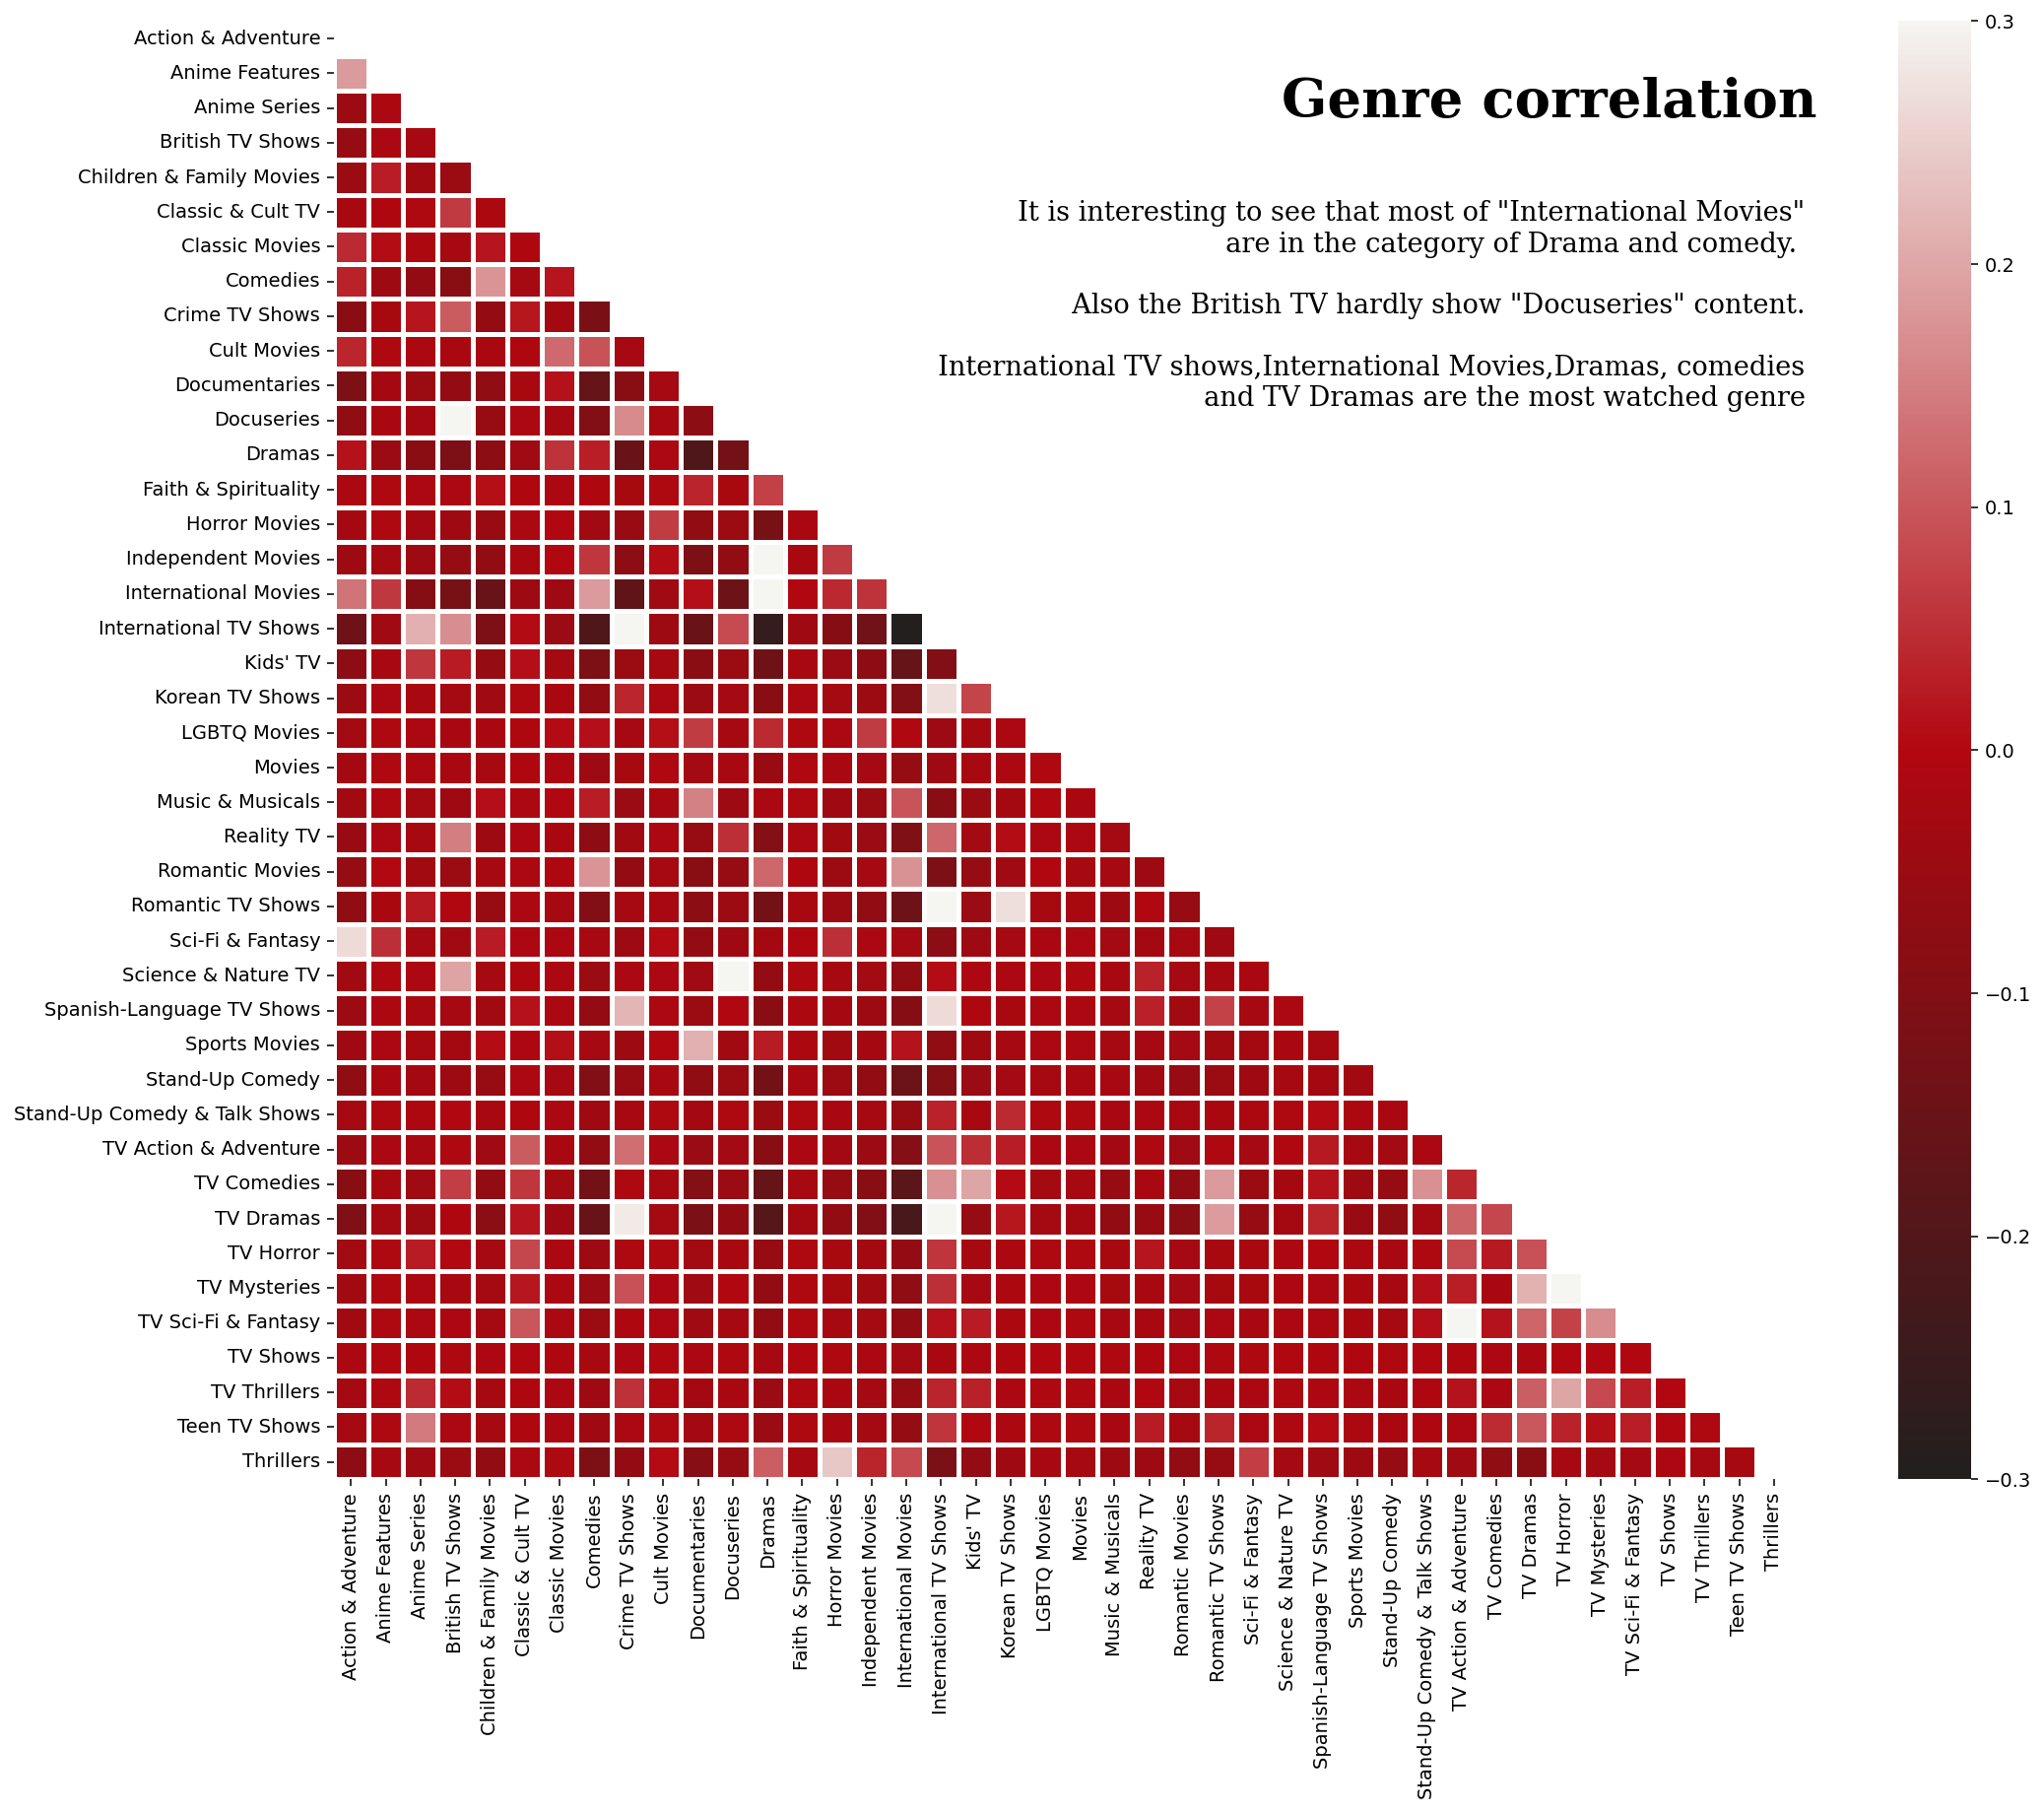

In [182]:
genre_heatmap(netflix_data, 'Movie & TV',text_)
plt.show()

## Splitting the data into Movies and TV Shows

Splitting the data into movies ans TV shoes also reveal a lot!

There are 20 types in the Netflix Movie Dataset


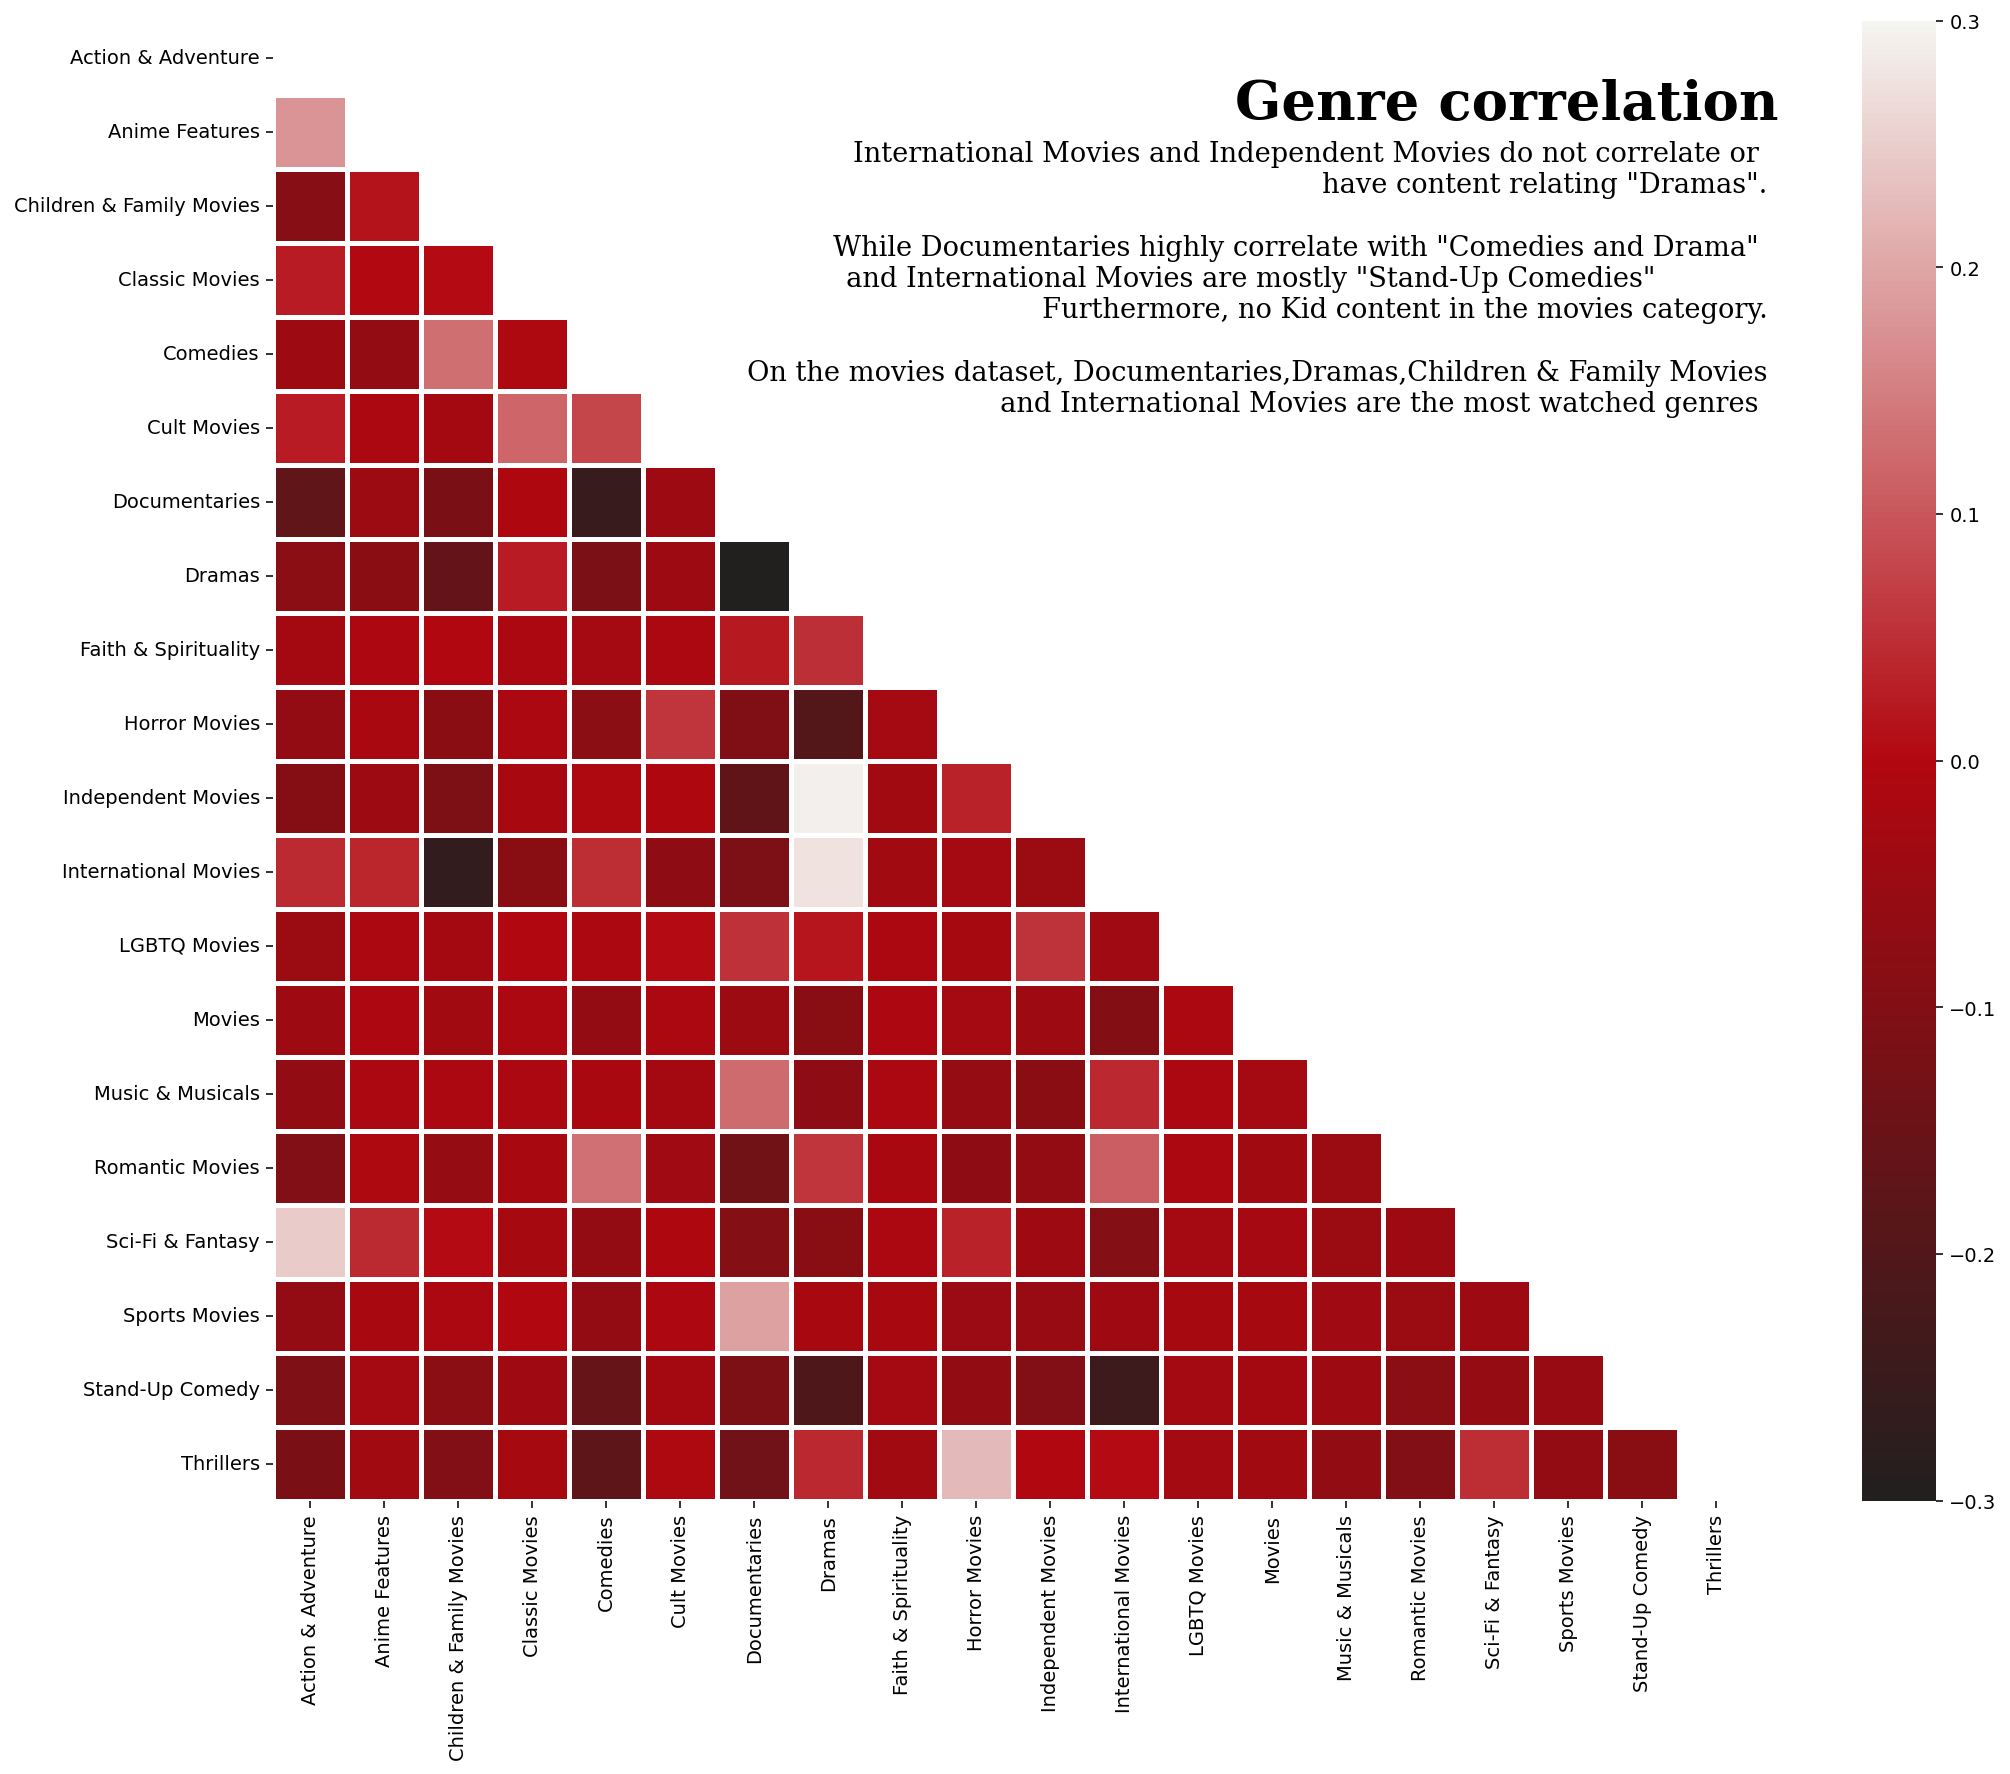

In [188]:
text_ =     ('''International Movies and Independent Movies do not correlate or 
             have content relating "Dramas".
             
             While Documentaries highly correlate with "Comedies and Drama" 
             and International Movies are mostly "Stand-Up Comedies"             
             Furthermore, no Kid content in the movies category.
             
             On the movies dataset, Documentaries,Dramas,Children & Family Movies
             and International Movies are the most watched genres 
             ''')

movies_data = netflix_data[netflix_data["type"] == "Movie"]


genre_heatmap(movies_data, 'Movie',text_)
plt.show()

There are 22 types in the Netflix TV Dataset


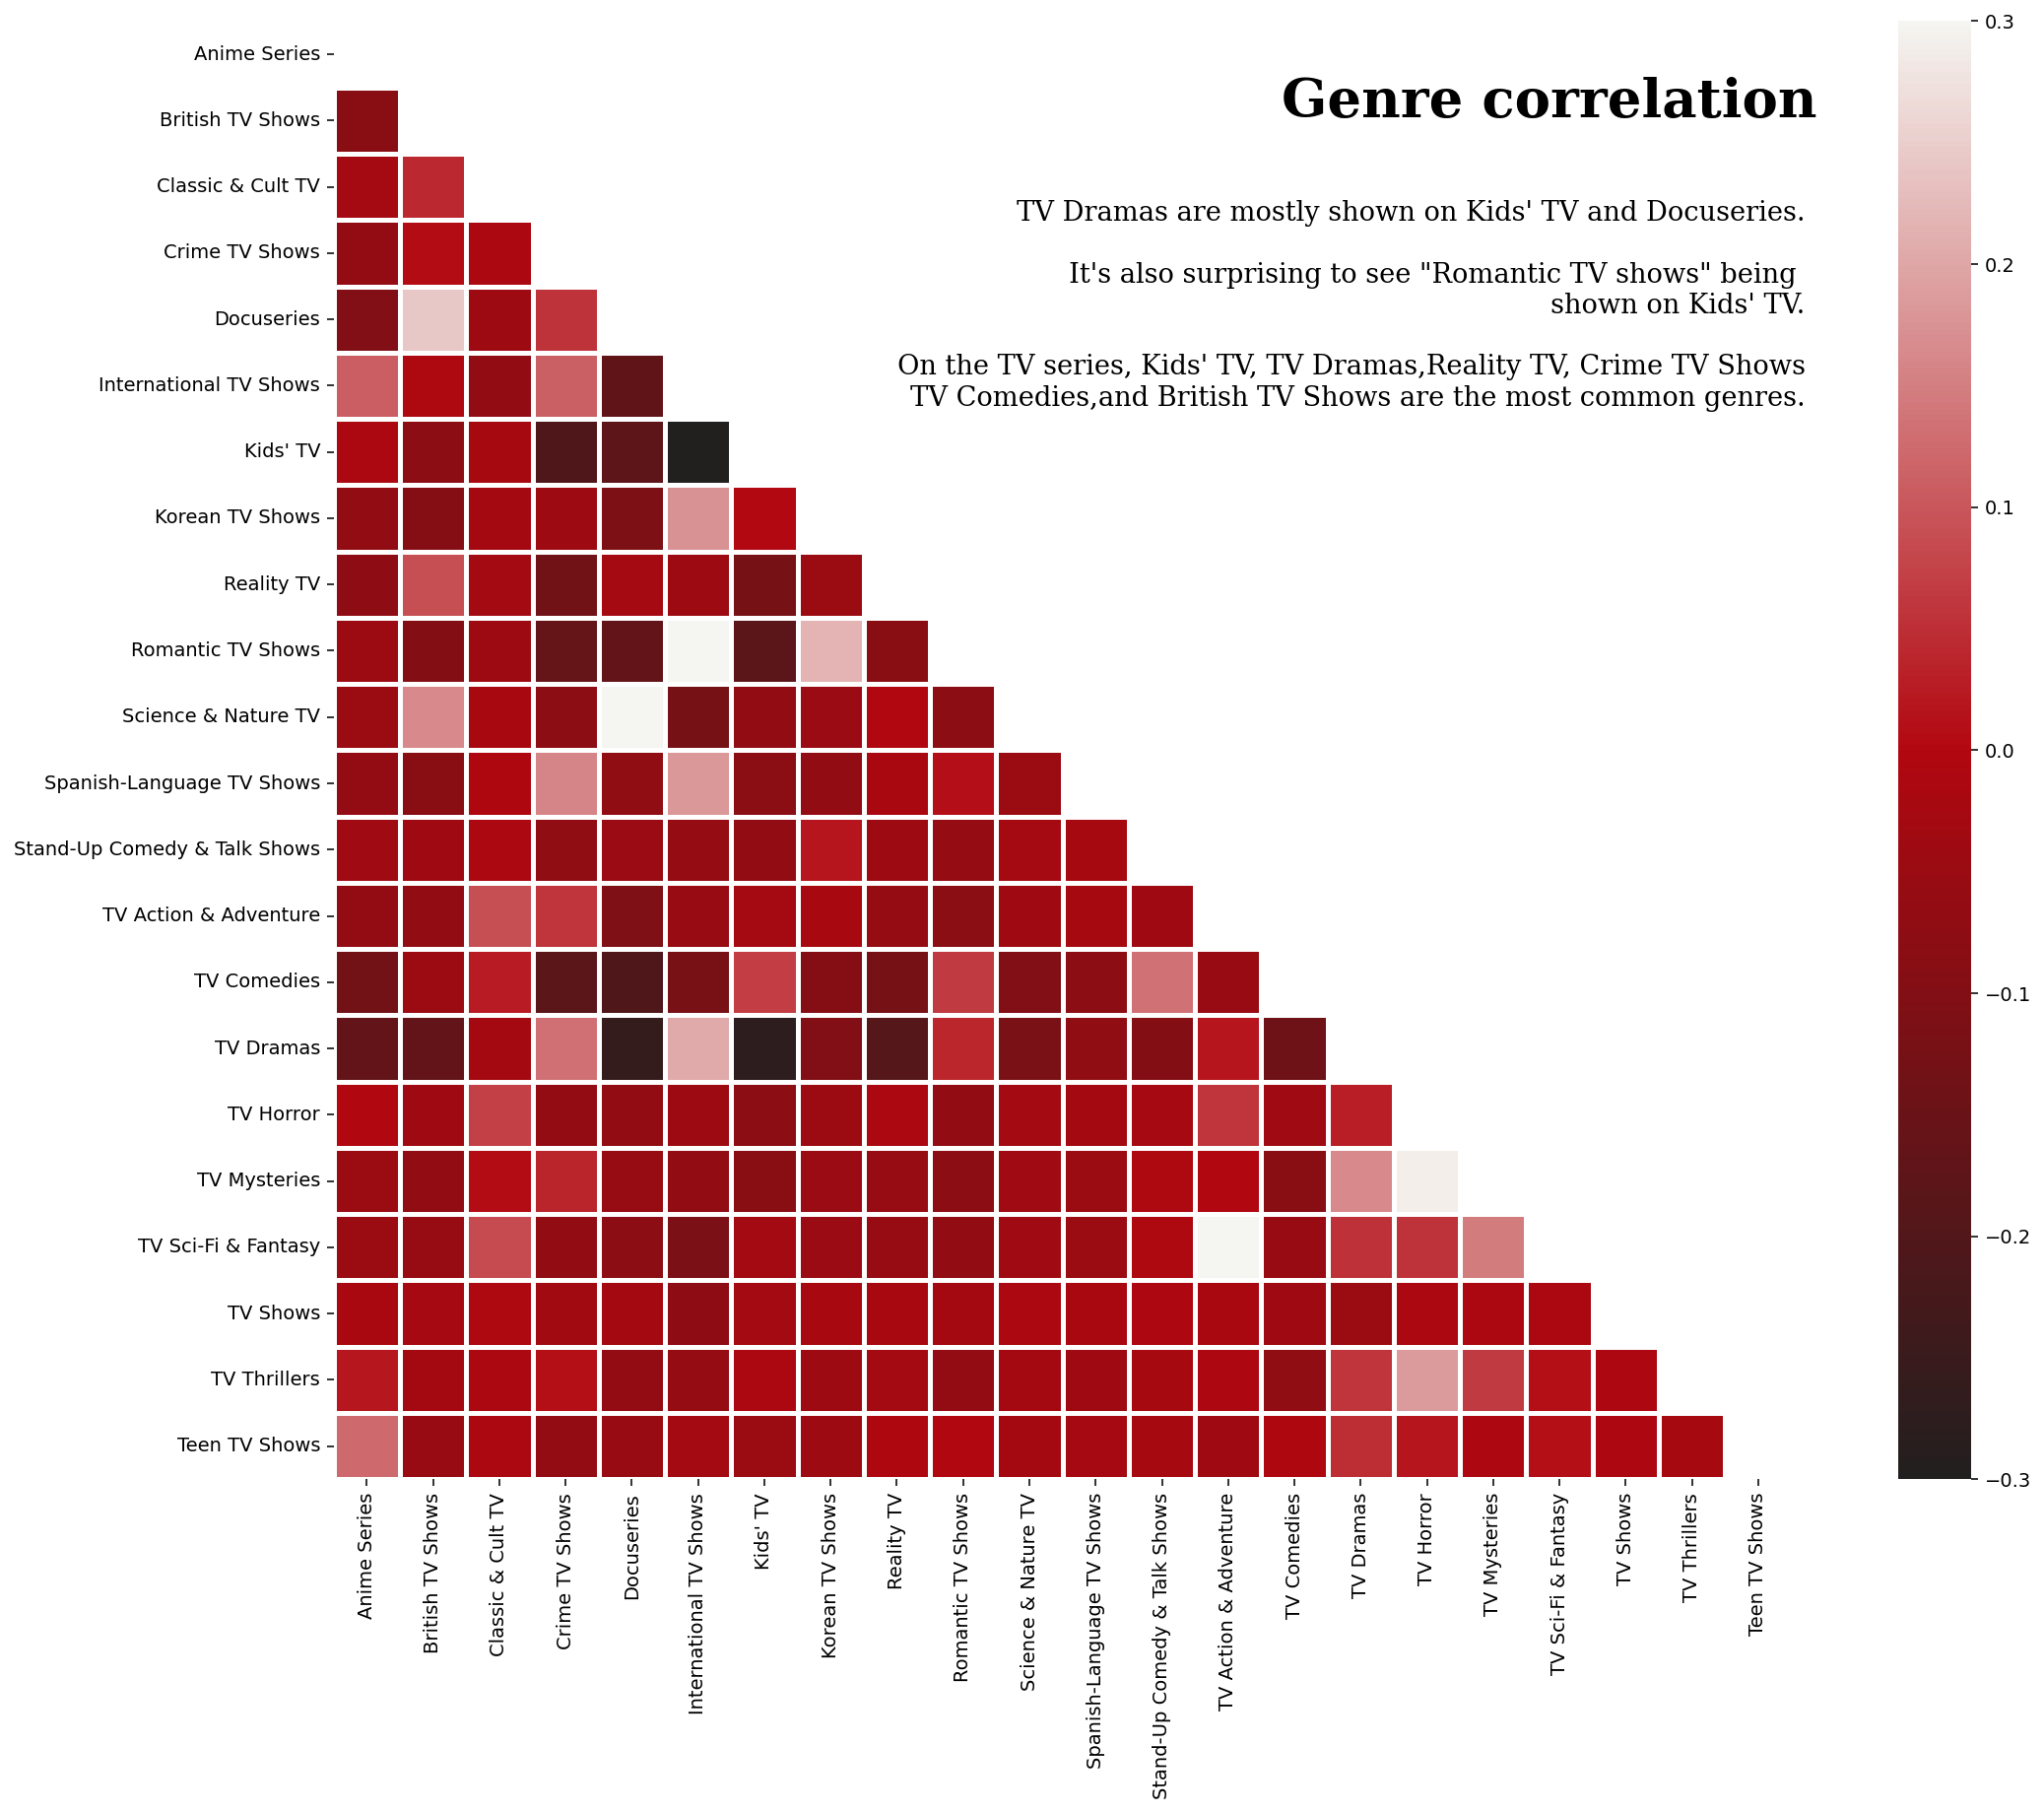

In [189]:
text_ =     ('''
             TV Dramas are mostly shown on Kids' TV and Docuseries.
             
             It's also surprising to see "Romantic TV shows" being 
             shown on Kids' TV.
             
             On the TV series, Kids' TV, TV Dramas,Reality TV, Crime TV Shows
             TV Comedies,and British TV Shows are the most common genres.
             ''')

tv_data = netflix_data[netflix_data["type"] == "TV Show"]

genre_heatmap(tv_data, 'TV',text_)
plt.show()

## Rating Distribution

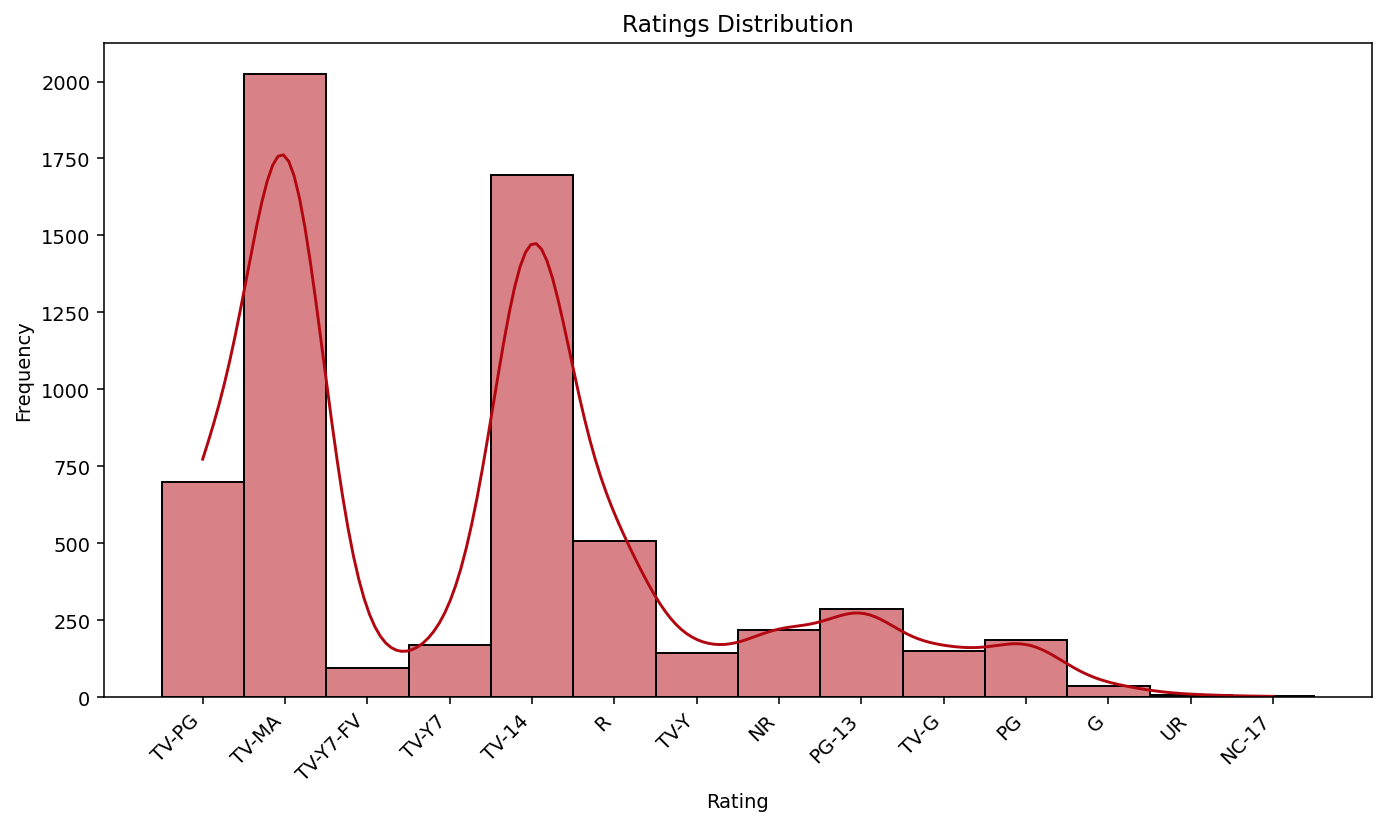

In [164]:
plt.figure(figsize=(10,6))
sns.histplot(netflix_data['rating'], bins=5, kde=True,color='#b20710')
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [178]:
order = pd.DataFrame(netflix_data.groupby('rating')['genre'].sum().sort_values(ascending=False).reset_index())
rating_order = list(order['rating'])

mf = netflix_data.groupby('type')['rating'].value_counts().unstack().sort_index().fillna(0).astype(int)[rating_order]

movie = mf.loc['Movie']
tv = - mf.loc['TV Show']


fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(movie.index, movie, width=0.5, color='#b20710', alpha=0.8, label='Movie')
ax.bar(tv.index, tv, width=0.5, color='#221f1f', alpha=0.8, label='TV Show')
#ax.set_ylim(-35, 50)

# Annotations
for i in tv.index:
    ax.annotate(f"{-tv[i]}", 
                   xy=(i, tv[i] - 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')   

for i in movie.index:
    ax.annotate(f"{movie[i]}", 
                   xy=(i, movie[i] + 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 1, 'Rating distribution by Film & TV Show', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.89, 
'''It is observed that some ratings are only applicable to Movies and not TVs 
The most common categories for both Movies & TV Shows are TV-MA and TV-14.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.755,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()



In [166]:
# Export clean data for use in R plotting

netflix_data.to_csv('Netflix_shows_movies.csv')